In [1]:
import os
import sys
import torch
import torch.nn as nn
import copy
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'


In [2]:
def plot_loss(history, ax=None, maxy=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    loss = history[:,0]
    val_loss = history[:,1]
    if maxy:
        ax.set_ylim(0,maxy)
    else:
        ax.set_ylim(0,torch.max(val_loss))
    ax.spines['top'].set_visible(False)   
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)
    ax.plot(loss, label='train_loss')
    ax.plot(val_loss, label='val_loss')
    ax.legend(loc='lower right')
    plt.tight_layout()
    if file:
#         plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")
        plt.savefig(f"{os.environ['HOME']}/{file}.pdf")
        
def plot_accur(history, ax=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epochs")
    accur = history[:,2]
    val_accur = history[:,3]
    ax.set_ylim(0,1.05)
    ax.plot(accur, label='accur')
    ax.plot(val_accur, label='val_accur')
    ax.spines['top'].set_visible(False)    
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)
    ax.legend(loc='lower right')
    plt.tight_layout()
    if file:
#         plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")
        plt.savefig(f"{os.environ['HOME']}/{file}.pdf")
        
def imgrid(images, digits, dim=(5,5), figsize=(4, 4)):
    fig, axes = plt.subplots(*dim, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        img_as_row = images[i]
        img28x28 = img_as_row.reshape(28,28)
        ax.axis('off') # don't show x, y axes
        ax.imshow(img28x28, cmap='Greys')
        ax.text(0, 8, digits[i], color='#313695', fontsize=15)

In [3]:
df_mnist = pd.read_csv("https://mlbook.explained.ai/data/mnist-10k-sample.csv.zip")
X = df_mnist.drop('digit', axis=1).values # get just pixels
y = df_mnist['digit'].values              # get just digit value

In [4]:
# shuffle
n = len(X)
idx = np.random.randint(0,n,n)
X = X[idx,:]
y = y[idx]

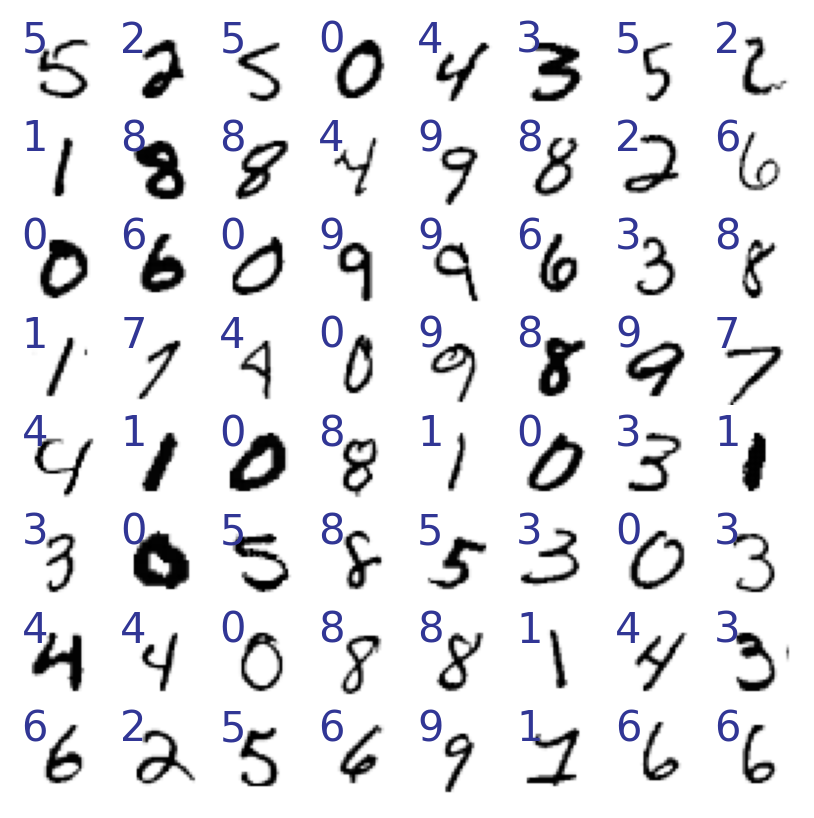

In [5]:
imgrid(X,digits=y,dim=(8,8),figsize=(5,5))

In [6]:
device = torch.device('cpu')
X = torch.tensor(X).float().to(device)
y = torch.tensor(y).to(device)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

##1. Train with one batch##

In [7]:
def sgdtrain(model, X_train, y_train, X_test, y_test, 
             learning_rate = .0001, nepochs=2000, batch_size=32):
    n = len(X_train)
    nbatches = n // batch_size
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = []
    best_loss = 1e10
    best_model = None
    best_epoch = -1
    for epoch in range(nepochs+1):
        epoch_training_loss = 0.0
        # Must shuffle before each epoch
        shuffle_idx = torch.randperm(len(X_train))
        X_train_shuffled = X_train[shuffle_idx]
        y_train_shuffled = y_train[shuffle_idx]
        for p in range(0, n, batch_size):  # do one epoch
            # extract a batch at index p
            batch_X = X_train_shuffled[p:p+batch_size]
            batch_y = y_train_shuffled[p:p+batch_size]
            y_pred = model(batch_X)
            # Assume model yields softmax probabilities
            loss = F.cross_entropy(y_pred, batch_y)
            epoch_training_loss += loss.detach().item()

            optimizer.zero_grad()
            loss.backward() # autograd computes w1.grad, b1.grad, ...
            optimizer.step()

        epoch_training_loss /= nbatches # average batch loss

        # Computing metrics in a no_grad() block is for memory efficiency and speed;
        # means to avoid doing any of the auto gradient computations
        with torch.no_grad():
            y_pred = model(X_train)
            y_pred = torch.argmax(y_pred, axis=1)
            ncorrect = torch.sum(y_pred==y_train)
            accur = ncorrect.float() / len(y_train)

            y_test_pred = model(X_test)
            loss_test = F.cross_entropy(y_test_pred, y_test)
            y_test_pred = torch.argmax(y_test_pred, axis=1)
            ncorrect = torch.sum(y_test_pred==y_test)
            loss_accur = ncorrect.float() / len(y_test)
        

        history.append((loss.item(), loss_test, accur, loss_accur))
        if loss_test < best_loss:
            best_loss = loss_test
            best_model = copy.deepcopy(model)
            best_epoch = epoch
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} cross entropy loss {loss:7.4f}   test loss {loss_test:7.4f}")

    print(f"BEST test cross entropy loss {best_loss:.3f} at epoch {best_epoch}")
    return torch.tensor(history), best_model

In [8]:
model = nn.Sequential(
    nn.Linear(784, 50),
    nn.ReLU(),
    nn.Linear(50, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

model = model.to(device) 

In [9]:
%%time

history,_ = sgdtrain(model, X_train, y_train, X_test, y_test,
                     learning_rate = .03, nepochs=1000,
                     batch_size=len(X_train) # perform batch not mini-batch gradient descent
                  )

Epoch    0 cross entropy loss  2.3023   test loss  2.1828
Epoch  100 cross entropy loss  1.4873   test loss  1.5110
Epoch  200 cross entropy loss  1.4814   test loss  1.5059
Epoch  300 cross entropy loss  1.4797   test loss  1.5041
Epoch  400 cross entropy loss  1.4786   test loss  1.5042
Epoch  500 cross entropy loss  1.4780   test loss  1.5049
Epoch  600 cross entropy loss  1.4780   test loss  1.5048
Epoch  700 cross entropy loss  1.4776   test loss  1.5048
Epoch  800 cross entropy loss  1.4773   test loss  1.5037
Epoch  900 cross entropy loss  1.4768   test loss  1.5034
Epoch 1000 cross entropy loss  1.4754   test loss  1.5030
BEST test cross entropy loss 1.502 at epoch 924
CPU times: user 1min 8s, sys: 1.5 s, total: 1min 10s
Wall time: 1min 14s


In [10]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.985


In [11]:
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.957


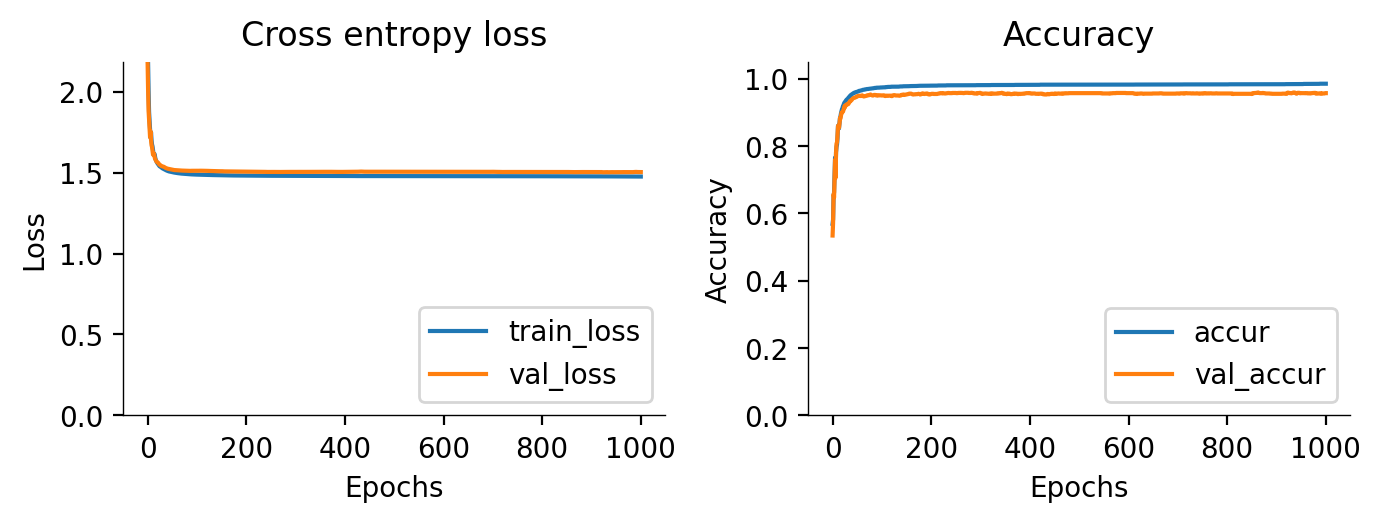

In [12]:
fig, axes = plt.subplots(1,2, figsize=(7,2.5))
plot_loss(history, ax=axes[0])
plot_accur(history, ax=axes[1])
axes[0].set_title("Cross entropy loss")
axes[1].set_title("Accuracy")
plt.show()

##2. Train with Minibatch##


In [13]:
%%time

model = nn.Sequential(
    nn.Linear(784, 50),
    nn.ReLU(),
    nn.Linear(50, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

model = model.to(device) 


history,_ = sgdtrain(model, X_train, y_train, X_test, y_test,
                     learning_rate = .001, # small learning rate due to imprecise gradients
                     nepochs=50,           # very few iterations for speed
                     batch_size=8          # very small batch size
                  )

Epoch    0 cross entropy loss  1.5234   test loss  1.5639
Epoch    5 cross entropy loss  1.4621   test loss  1.5219
Epoch   10 cross entropy loss  1.5861   test loss  1.5138
Epoch   15 cross entropy loss  1.5872   test loss  1.5108
Epoch   20 cross entropy loss  1.4616   test loss  1.5048
Epoch   25 cross entropy loss  1.4780   test loss  1.5023
Epoch   30 cross entropy loss  1.4612   test loss  1.5037
Epoch   35 cross entropy loss  1.4612   test loss  1.4998
Epoch   40 cross entropy loss  1.4612   test loss  1.5027
Epoch   45 cross entropy loss  1.4612   test loss  1.5015
Epoch   50 cross entropy loss  1.5816   test loss  1.5003
BEST test cross entropy loss 1.498 at epoch 39
CPU times: user 1min 7s, sys: 621 ms, total: 1min 8s
Wall time: 1min 9s


In [14]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.985


In [15]:
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.961


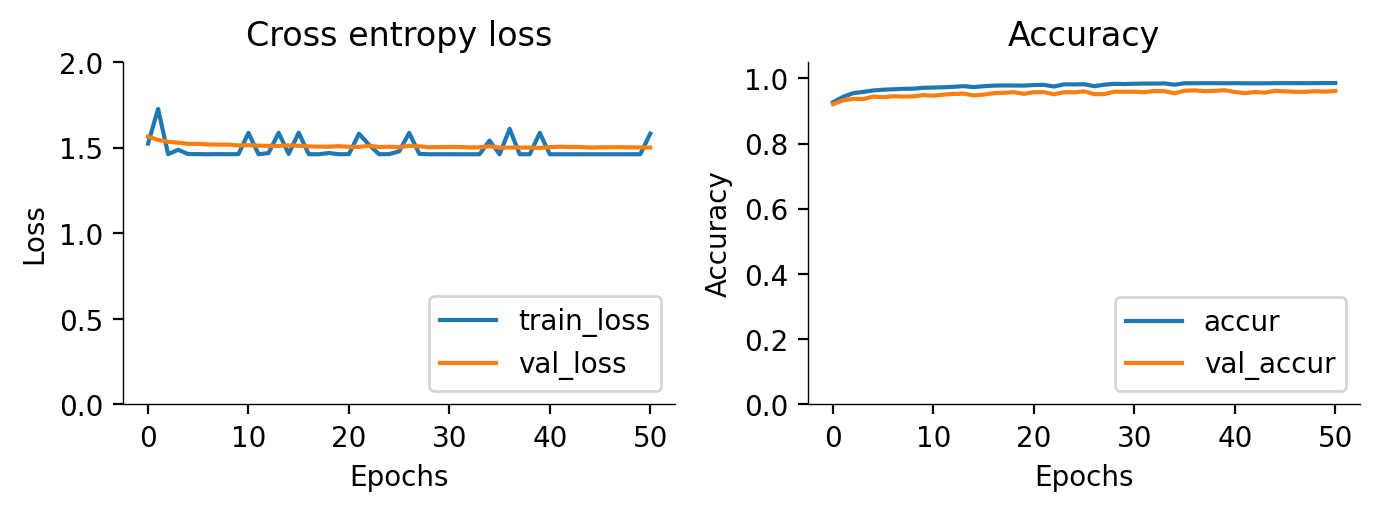

In [16]:
fig, axes = plt.subplots(1,2, figsize=(7,2.5))
plot_loss(history, ax=axes[0], maxy=2)
plot_accur(history, ax=axes[1])
axes[0].set_title("Cross entropy loss")
axes[1].set_title("Accuracy")
plt.show()

##3. Shallow VS Deep Network##

In [17]:
model = nn.Sequential(
    nn.Linear(784, 50),
    nn.ReLU(),
    nn.Linear(50,30),
    nn.ReLU(),
    nn.Linear(30,20),
    nn.ReLU(),
    nn.Linear(20, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

model = model.to(device) 

In [18]:
%%time

history,_ = sgdtrain(model, X_train, y_train, X_test, y_test,
                     learning_rate = .03, nepochs=1000,
                     batch_size=len(X_train) # perform batch not mini-batch gradient descent
                  )

Epoch    0 cross entropy loss  2.3026   test loss  2.2957
Epoch  100 cross entropy loss  1.5769   test loss  1.5893
Epoch  200 cross entropy loss  1.5744   test loss  1.5879
Epoch  300 cross entropy loss  1.4887   test loss  1.5080
Epoch  400 cross entropy loss  1.4842   test loss  1.5036
Epoch  500 cross entropy loss  1.4829   test loss  1.5021
Epoch  600 cross entropy loss  1.4812   test loss  1.5045
Epoch  700 cross entropy loss  1.4809   test loss  1.5021
Epoch  800 cross entropy loss  1.4807   test loss  1.5027
Epoch  900 cross entropy loss  1.4807   test loss  1.5026
Epoch 1000 cross entropy loss  1.4807   test loss  1.5024
BEST test cross entropy loss 1.501 at epoch 523
CPU times: user 1min 41s, sys: 5.58 s, total: 1min 47s
Wall time: 1min 47s


In [19]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.980


In [20]:
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.959


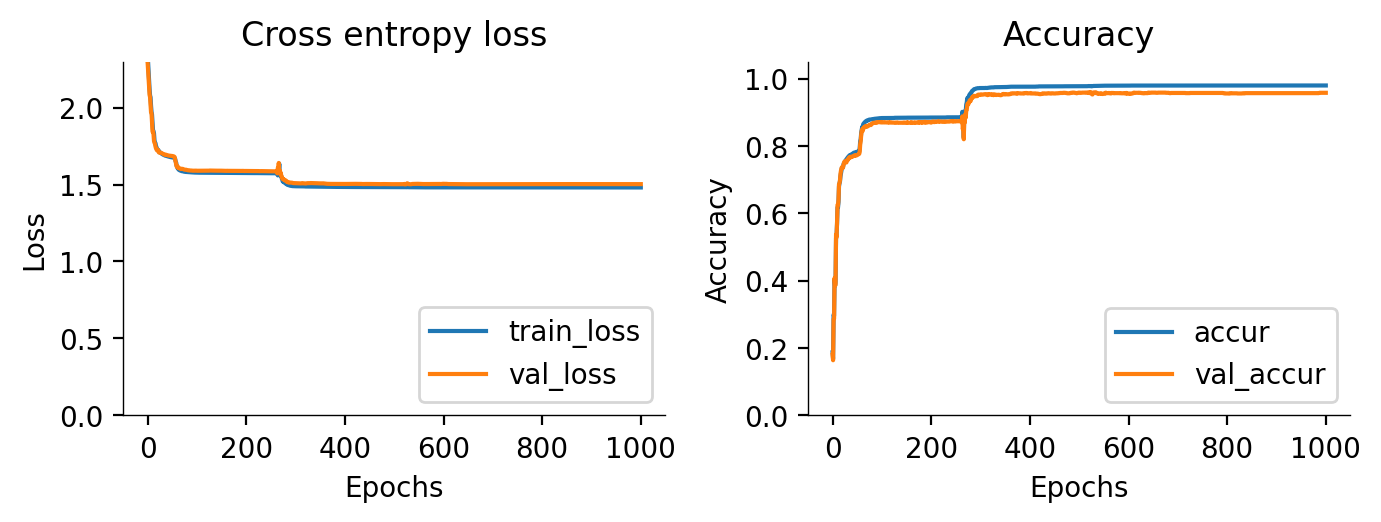

In [21]:
fig, axes = plt.subplots(1,2, figsize=(7,2.5))
plot_loss(history, ax=axes[0])
plot_accur(history, ax=axes[1])
axes[0].set_title("Cross entropy loss")
axes[1].set_title("Accuracy")
plt.show()

In [22]:
model = nn.Sequential(
    nn.Linear(784, 50),
    nn.ReLU(),
    nn.Linear(50,50),
    nn.ReLU(),
    nn.Linear(50, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

model = model.to(device) 

In [23]:
%%time

history,_ = sgdtrain(model, X_train, y_train, X_test, y_test,
                     learning_rate = .03, nepochs=1000,
                     batch_size=len(X_train) # perform batch not mini-batch gradient descent
                  )

Epoch    0 cross entropy loss  2.3028   test loss  2.2680
Epoch  100 cross entropy loss  1.5818   test loss  1.5955
Epoch  200 cross entropy loss  1.5760   test loss  1.5926
Epoch  300 cross entropy loss  1.5016   test loss  1.5157
Epoch  400 cross entropy loss  1.4781   test loss  1.4987
Epoch  500 cross entropy loss  1.4771   test loss  1.4971
Epoch  600 cross entropy loss  1.4771   test loss  1.4972
Epoch  700 cross entropy loss  1.4771   test loss  1.4972
Epoch  800 cross entropy loss  1.4769   test loss  1.4965
Epoch  900 cross entropy loss  1.4767   test loss  1.4965
Epoch 1000 cross entropy loss  1.4767   test loss  1.4965
BEST test cross entropy loss 1.496 at epoch 764
CPU times: user 1min 27s, sys: 3.27 s, total: 1min 30s
Wall time: 1min 30s


In [24]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.984


In [25]:
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.965


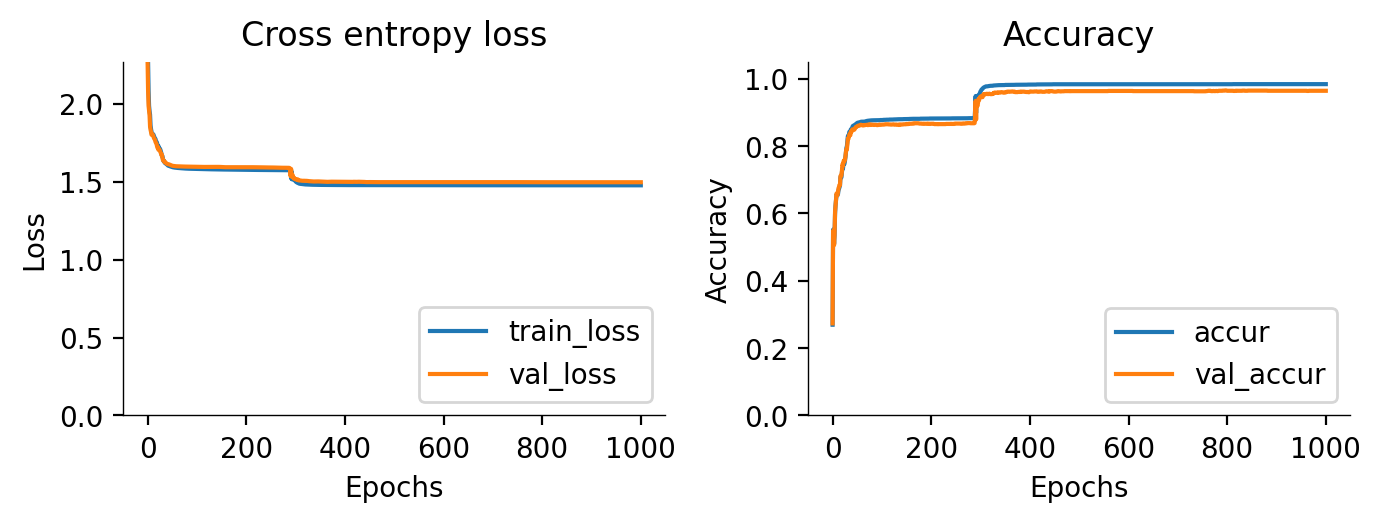

In [26]:
fig, axes = plt.subplots(1,2, figsize=(7,2.5))
plot_loss(history, ax=axes[0])
plot_accur(history, ax=axes[1])
axes[0].set_title("Cross entropy loss")
axes[1].set_title("Accuracy")
plt.show()


##4. Master Worker Computation Graph##




There are two ways of running distributed model:

On multiple GPUs (typically 2 to 8) installed on a single machine (single host, multi-device training).

On a cluster of many machines, each hosting one or multiple GPUs (multi-worker distributed training).

In [27]:
import torch
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.multiprocessing as mp

In [28]:
def train(rank, num_workers):

    # num_workers = 1
    # rank = 0

    # Initialize the distributed backend with the specified number of workers
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '29500'
    dist.init_process_group(
        backend="nccl",
        # init_method='tcp://localhost:23456',
        world_size=num_workers,
        rank=rank
    )

    # Define the neural network
    model = nn.Sequential(
        nn.Linear(100, 50),
        nn.ReLU(),
        nn.Linear(50, 10),  # 10 output classes (0-9)
        nn.Softmax(dim=1)
    )

    # Make the model distributed
    model = DDP(model)

    # Define the loss function and optimizer
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    # Load the dataset
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, sampler=train_sampler)

    # Train the model
    for epoch in range(1):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()


The workflow is shown below but we don't have 6 available GPUs and it makes the code not immediately runnable.

In [29]:
# Define the number of workers
num_workers = 6

# Define the training arguments for each worker
args = [
    ('--rank', str(rank), '--world-size', str(num_workers))
    for rank in range(num_workers)
]

# Launch the worker processes using torch.distributed.launch
mp.spawn(train, args=args, nprocs=num_workers, join=True)

ProcessExitedException: ignored

##5. Preventing Overfitting##

Explanation:

We add L1 regularization of weights by taking the 1-norm of all the weights in each layer of the model multiplied by a tuning parameter lambda.

Dropout is a layer in the neural network. During training of a neural network model, it will take the output from its previous layer, randomly select some of the neurons and zero them out before passing to the next layer, effectively ignored them.

We compare the effects of the two approaches on the model nby comparing with a Adam-based baseline.

In [30]:
def sgdtrain(model, X_train, y_train, X_test, y_test, 
             learning_rate = .0001, nepochs=2000, batch_size=32, weight_decay=0.0, l1_lambda=0.0):
    n = len(X_train)
    nbatches = n // batch_size
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = []
    best_loss = 1e10
    best_model = None
    best_epoch = -1
    for epoch in range(nepochs+1):
        epoch_training_loss = 0.0
        # Must shuffle before each epoch
        shuffle_idx = torch.randperm(len(X_train))
        X_train_shuffled = X_train[shuffle_idx]
        y_train_shuffled = y_train[shuffle_idx]
        for p in range(0, n, batch_size):  # do one epoch
            # extract a batch at index p
            batch_X = X_train_shuffled[p:p+batch_size]
            batch_y = y_train_shuffled[p:p+batch_size]
            y_pred = model(batch_X)

            # Assume model yields softmax probabilities
            l1_regularization_loss = torch.tensor(0).float()
            cross_entropy_loss = F.cross_entropy(y_pred, batch_y)
            for param in model.parameters():
                l1_regularization_loss += torch.norm(param, 1)**2
            l1_regularization_loss *= l1_lambda
            loss = cross_entropy_loss + l1_regularization_loss

            # loss = F.cross_entropy(y_pred, batch_y)
            epoch_training_loss += loss.detach().item()

            optimizer.zero_grad()
            loss.backward() # autograd computes w1.grad, b1.grad, ...
            optimizer.step()

        epoch_training_loss /= nbatches # average batch loss

        # Computing metrics in a no_grad() block is for memory efficiency and speed;
        # means to avoid doing any of the auto gradient computations
        with torch.no_grad():
            y_pred = model(X_train)
            y_pred = torch.argmax(y_pred, axis=1)
            ncorrect = torch.sum(y_pred==y_train)
            accur = ncorrect.float() / len(y_train)

            y_test_pred = model(X_test)
            loss_test = F.cross_entropy(y_test_pred, y_test)
            y_test_pred = torch.argmax(y_test_pred, axis=1)
            ncorrect = torch.sum(y_test_pred==y_test)
            loss_accur = ncorrect.float() / len(y_test)
        
        # Save all of the computations; loss.item() detaches
        # the hidden auto gradient computation graph.
        # Gets just the value. Otherwise, this procedure
        # runs out of memory on the GPU. 
        history.append((loss.item(), loss_test, accur, loss_accur))
        if loss_test < best_loss:
            best_loss = loss_test
            best_model = copy.deepcopy(model)
            best_epoch = epoch
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} cross entropy loss {loss:7.4f}   test loss {loss_test:7.4f}")

    print(f"BEST test cross entropy loss {best_loss:.3f} at epoch {best_epoch}")
    return torch.tensor(history), best_model


In [31]:
def show_result(model, X_train, X_test, y_train, y_test, history):
    y_pred = model(X_train)
    y_pred = torch.argmax(y_pred, axis=1)
    ncorrect = torch.sum(y_pred==y_train)
    train_accur = ncorrect.float() / len(y_train)
    print(f"Training accuracy {train_accur:.3f}")

    y_test_pred = model(X_test)
    y_test_pred = torch.argmax(y_test_pred, axis=1)
    ncorrect = torch.sum(y_test_pred==y_test)
    test_accur = ncorrect.float() / len(y_test)
    print(f"Validation accuracy {test_accur:.3f}")

    fig, axes = plt.subplots(1,2, figsize=(7,2.5))
    plot_loss(history, ax=axes[0], maxy=3)
    plot_accur(history, ax=axes[1])
    axes[0].set_title("Cross entropy loss")
    axes[1].set_title("Accuracy")
    plt.show()

## Baseline ##

In [32]:
model = nn.Sequential(
    nn.Linear(784, 300),
    nn.ReLU(),
    # nn.Linear(100, 50),  # 10 output classes (0-9)
    # nn.ReLU(),
    nn.Linear(300, 300),  # 10 output classes (0-9)
    nn.ReLU(),
    nn.Linear(300, 100),  # 10 output classes (0-9)
    nn.ReLU(),
    nn.Linear(100, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

model = model.to(device) # make sure the model runs on the GPU as well

In [33]:
history,_ = sgdtrain(model, X_train, y_train, X_test, y_test,
                     learning_rate = 1e-4, # small learning rate due to imprecise gradients
                     nepochs = 40,           # very few iterations for speed
                     batch_size = 8,          # very small batch size
                     l1_lambda = 0.0,
                     weight_decay = 0.0,
                  )

Epoch    0 cross entropy loss  1.5839   test loss  1.6137
Epoch    4 cross entropy loss  1.4694   test loss  1.5362
Epoch    8 cross entropy loss  1.4613   test loss  1.5213
Epoch   12 cross entropy loss  1.4612   test loss  1.5135
Epoch   16 cross entropy loss  1.4677   test loss  1.5093
Epoch   20 cross entropy loss  1.4612   test loss  1.5029
Epoch   24 cross entropy loss  1.4612   test loss  1.5027
Epoch   28 cross entropy loss  1.4614   test loss  1.5039
Epoch   32 cross entropy loss  1.4612   test loss  1.5004
Epoch   36 cross entropy loss  1.4678   test loss  1.4949
Epoch   40 cross entropy loss  1.4612   test loss  1.4963
BEST test cross entropy loss 1.495 at epoch 36


Training accuracy 0.984
Validation accuracy 0.964


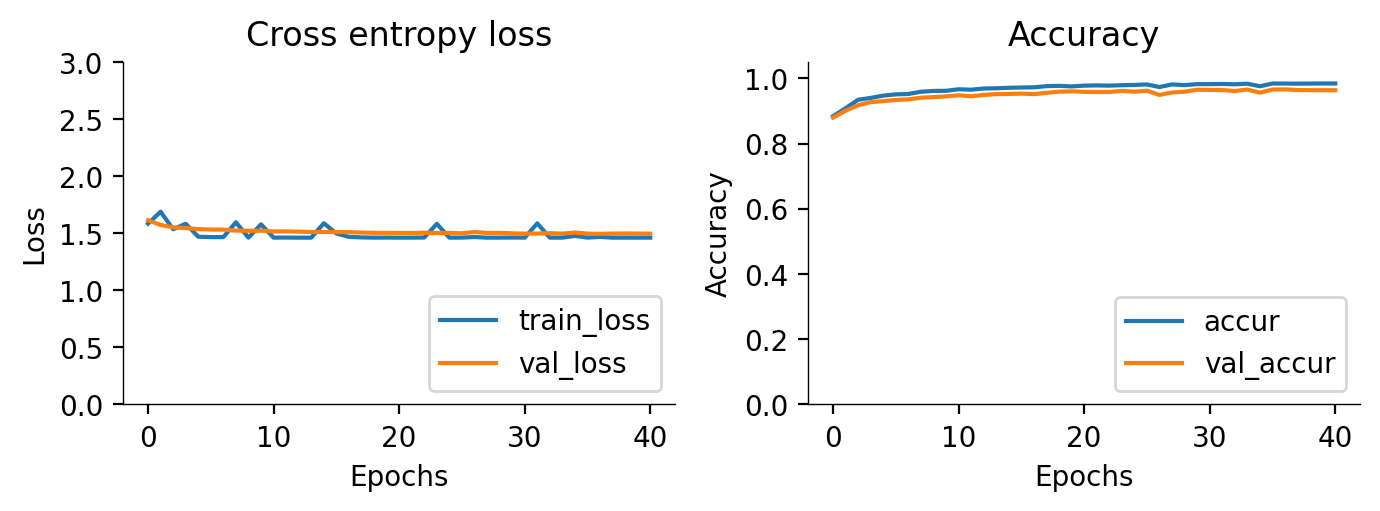

In [34]:
show_result(model, X_train, X_test, y_train, y_test, history)

## L1 Regularization ##

In [35]:
model = nn.Sequential(
    nn.Linear(784, 300),
    nn.ReLU(),
    # nn.Linear(100, 50),  # 10 output classes (0-9)
    # nn.ReLU(),
    nn.Linear(300, 300),  # 10 output classes (0-9)
    nn.ReLU(),
    nn.Linear(300, 100),  # 10 output classes (0-9)
    nn.ReLU(),
    nn.Linear(100, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

model = model.to(device) # make sure the model runs on the GPU as well

In [36]:
history,_ = sgdtrain(model, X_train, y_train, X_test, y_test,
                     learning_rate = 1e-4, # small learning rate due to imprecise gradients
                     nepochs = 40,           # very few iterations for speed
                     batch_size = 8,          # very small batch size
                     l1_lambda = 1e-9,
                     weight_decay = 0.0,
                  )

Epoch    0 cross entropy loss  1.5447   test loss  1.7100
Epoch    4 cross entropy loss  1.5327   test loss  1.5481
Epoch    8 cross entropy loss  1.5996   test loss  1.5228
Epoch   12 cross entropy loss  1.5733   test loss  1.5119
Epoch   16 cross entropy loss  1.4757   test loss  1.5090
Epoch   20 cross entropy loss  1.4900   test loss  1.5058
Epoch   24 cross entropy loss  1.4751   test loss  1.5065
Epoch   28 cross entropy loss  1.4717   test loss  1.5034
Epoch   32 cross entropy loss  1.4708   test loss  1.5004
Epoch   36 cross entropy loss  1.4707   test loss  1.4993
Epoch   40 cross entropy loss  1.4694   test loss  1.4991
BEST test cross entropy loss 1.499 at epoch 37


Training accuracy 0.984
Validation accuracy 0.963


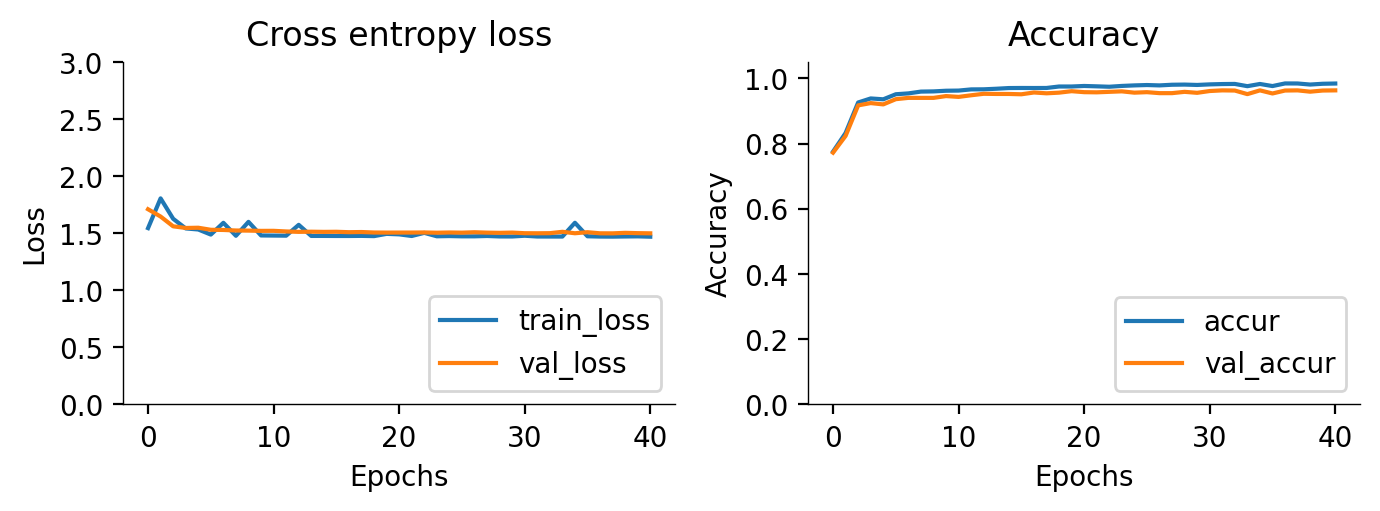

In [37]:
show_result(model, X_train, X_test, y_train, y_test, history)

## Dropout ##

In [38]:
model = nn.Sequential(
    nn.Linear(784, 300),
    nn.ReLU(),
    nn.Dropout(0.05),
    nn.Linear(300, 300),  # 10 output classes (0-9)
    nn.ReLU(),
    nn.Dropout(0.05),
    nn.Linear(300, 100),  # 10 output classes (0-9)
    nn.ReLU(),
    nn.Dropout(0.05),
    nn.Linear(100, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

model = model.to(device) # make sure the model runs on the GPU as well

In [39]:
history,_ = sgdtrain(model, X_train, y_train, X_test, y_test,
                     learning_rate = 1e-4, # small learning rate due to imprecise gradients
                     nepochs=40,           # very few iterations for speed
                     batch_size=8,          # very small batch size
                     l1_lambda = 0,
                     weight_decay = 0.0,                  
                     )

Epoch    0 cross entropy loss  1.7377   test loss  1.7108
Epoch    4 cross entropy loss  1.6126   test loss  1.6168
Epoch    8 cross entropy loss  1.7584   test loss  1.6031
Epoch   12 cross entropy loss  1.6197   test loss  1.5951
Epoch   16 cross entropy loss  1.6712   test loss  1.5338
Epoch   20 cross entropy loss  1.4792   test loss  1.5041
Epoch   24 cross entropy loss  1.4656   test loss  1.5024
Epoch   28 cross entropy loss  1.4653   test loss  1.5052
Epoch   32 cross entropy loss  1.4612   test loss  1.4935
Epoch   36 cross entropy loss  1.4612   test loss  1.4942
Epoch   40 cross entropy loss  1.4612   test loss  1.4981
BEST test cross entropy loss 1.491 at epoch 39


Training accuracy 0.988
Validation accuracy 0.962


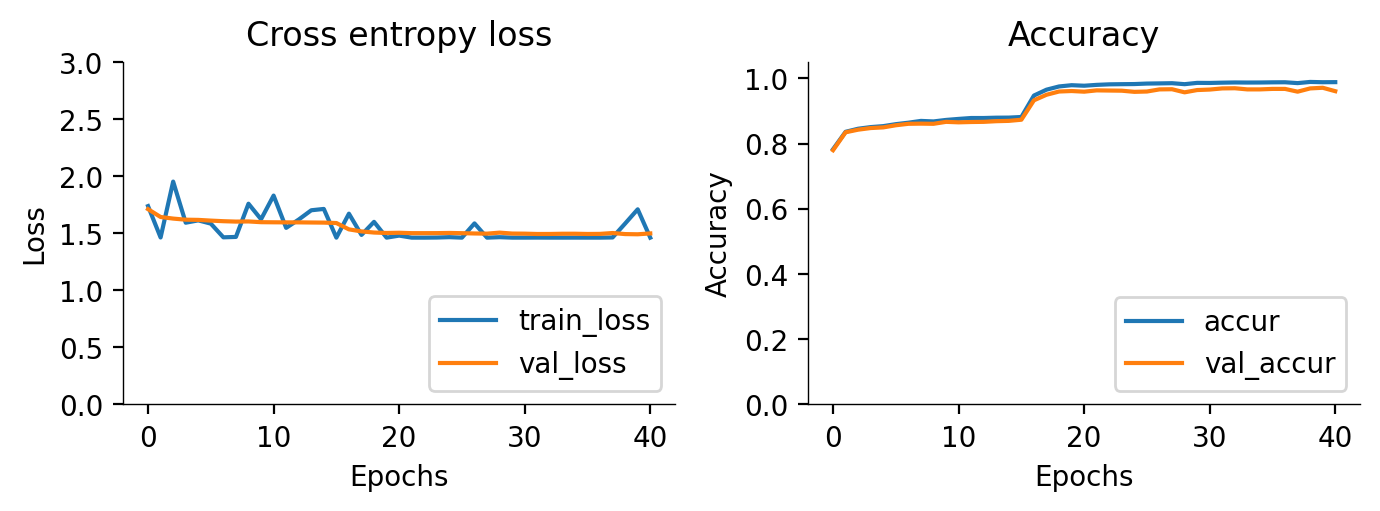

In [40]:
show_result(model, X_train, X_test, y_train, y_test, history)

Dropout works well to reduce the complexity of the baseline model by canceling out some of the neurons. The accuracy is thus also higher than the baseline. On the other hand, L1 did not help much in this model and hyperparameter setup.

## 6. Weight Decay  ##

The methods that smooth loss landscape include batch normalization and weight decay.

Batch normalization works by normalizing the inputs to each layer, which helps reduce the internal covariate shift in the network and can lead to a smoother loss landscape. This can help the optimizer converge faster and more reliably during training.

Weight decay, on the other hand, is a regularization technique that adds a penalty term to the loss function to discourage large weights in the model. This penalty term can help smooth the loss landscape by discouraging the model from fitting to noisy or irrelevant features in the data, which can cause the loss landscape to become more jagged and difficult to optimize.

In [41]:
model = nn.Sequential(
    nn.Linear(784, 300),
    nn.ReLU(),
    # nn.Linear(100, 50),  # 10 output classes (0-9)
    # nn.ReLU(),
    nn.Linear(300, 300),  # 10 output classes (0-9)
    nn.ReLU(),
    nn.Linear(300, 100),  # 10 output classes (0-9)
    nn.ReLU(),
    nn.Linear(100, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

model = model.to(device) # make sure the model runs on the GPU as well

In [42]:
history,_ = sgdtrain(model, X_train, y_train, X_test, y_test,
                     learning_rate = 1e-4, # small learning rate due to imprecise gradients
                     nepochs=40,           # very few iterations for speed
                     batch_size=8,          # very small batch size
                     l1_lambda = 0,
                     weight_decay = 1e-5,                  
                     )

Epoch    0 cross entropy loss  1.8003   test loss  1.6807
Epoch    4 cross entropy loss  1.4636   test loss  1.5369
Epoch    8 cross entropy loss  1.5196   test loss  1.5219
Epoch   12 cross entropy loss  1.5859   test loss  1.5084
Epoch   16 cross entropy loss  1.4612   test loss  1.5036
Epoch   20 cross entropy loss  1.4634   test loss  1.5108
Epoch   24 cross entropy loss  1.4615   test loss  1.5010
Epoch   28 cross entropy loss  1.4705   test loss  1.5099
Epoch   32 cross entropy loss  1.4614   test loss  1.5059
Epoch   36 cross entropy loss  1.4615   test loss  1.4968
Epoch   40 cross entropy loss  1.4613   test loss  1.4966
BEST test cross entropy loss 1.495 at epoch 38


Training accuracy 0.984
Validation accuracy 0.965


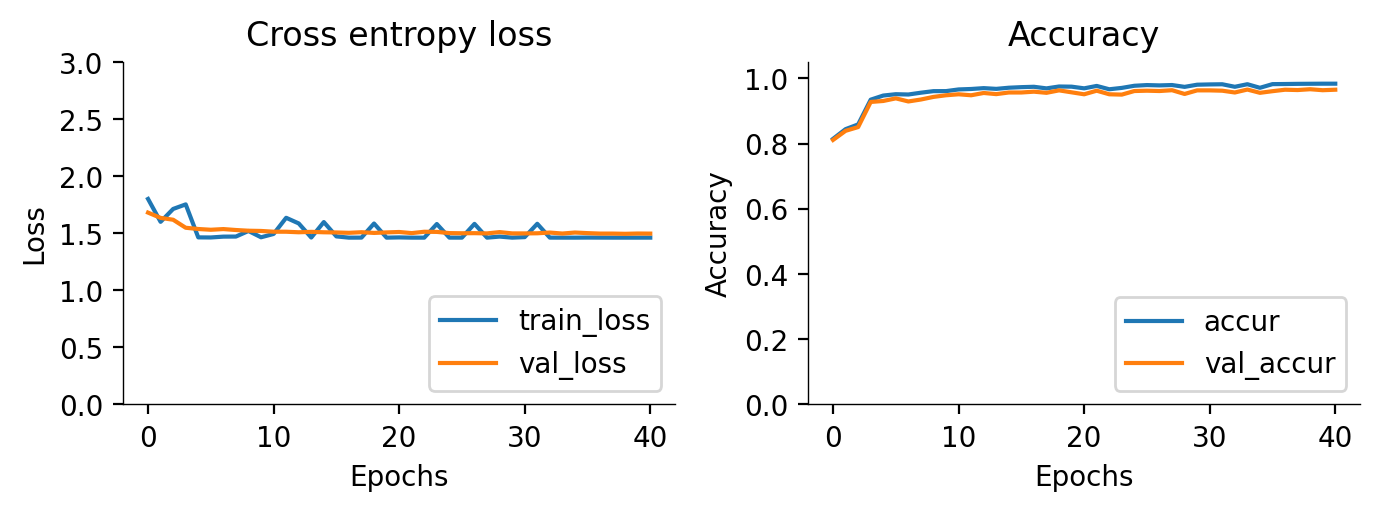

In [43]:
show_result(model, X_train, X_test, y_train, y_test, history)